# Customer Churn Prediction

**Author:** Shedrack Chinonso  
**Date:** 2026-01-27  
**Project Type:** Machine Learning / Classification

This project investigates customer churn using historical customer data. The goal is to build a predictive model that identifies customers likely to leave and to extract insights that can support business retention strategies.


# Customer Churn Prediction (Telco)  End-to-End Data Science Pipeline

## Goal
Predict whether a customer will churn, and translate the model into decisions:
- Who is most likely to churn?
- What is driving churn?
- What actions should the business take?

## Why churn matters
For subscription businesses, reducing churn is often cheaper than acquiring new customers.
Even small churn reductions can compound into meaningful revenue impact.

---

> **Reproducibility Note:**  
> All analysis steps are fully reproducible using the provided dataset
> and code. Random seeds were fixed where applicable to ensure consistent
> results across runs.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report, roc_auc_score, RocCurveDisplay,
    ConfusionMatrixDisplay, PrecisionRecallDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional: better gradient boosting
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    from sklearn.ensemble import HistGradientBoostingClassifier

RANDOM_STATE = 42

## 1. Data Acquisition

We will use the **Telco Customer Churn** dataset (IBM sample copy).
It’s realistic: demographics, services, billing, and churn label.

**Direct CSV link (loadable):**  
https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

In [3]:
# Load data

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Quick shape + types
print(df.shape)
df.info()

(7043, 21)
<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    


The dataset contains 7,043 records and 21 columns. This confirms the scale of the analysis and sets expectations for preprocessing and overall analysis complexity.


## 2. Basic data checks

Things I check early:
- Missing values (including "blank strings" pretending to be numbers)
- Target balance (how many churned vs not)
- Duplicates / ID columns

In [5]:
# Quick checks

df.duplicated().sum(), df.isnull().sum().head(10)

(0,
 customerID         0
 gender             0
 SeniorCitizen      0
 Partner            0
 Dependents         0
 tenure             0
 PhoneService       0
 MultipleLines      0
 InternetService    0
 OnlineSecurity     0
 dtype: int64)

In [6]:
# Target distribution
df["Churn"].value_counts(dropna=False)

Churn
No     5174
Yes    1869
Name: count, dtype: int64

The churn label is imbalanced (many more 'No' than 'Yes'). This matters because later results should be interpreted with class-aware measures rather than relying on the majority class.


In [7]:
# Churn rate
churn_rate = (df["Churn"] == "Yes").mean()
print(f"Churn rate: {churn_rate:.3f}")

Churn rate: 0.265


The churn rate is about 26.5%, which provides a simple baseline for how common churn is in this dataset and helps frame the business impact of the patterns explored next.


## 3. Cleaning + Wrangling

Notes about this dataset:
- `customerID` is an identifier → drop (not predictive)
- `TotalCharges` is sometimes stored as text, with blank strings for new customers  
  We'll coerce to numeric and impute missing.
- Ensure the target is binary (1 churned, 0 stayed).

In [8]:
# Cleaning

df = df.copy()

# Drop ID
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# Fix TotalCharges: convert to numeric (blanks become NaN)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Target encoding
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype("int64")

df[["TotalCharges", "Churn"]].head()

,TotalCharges,Churn
0,29.85,0
1,1889.50,0
2,108.15,1
3,1840.75,0
4,151.65,1


The customer identifier is removed because it carries no behavioral information and would introduce noise without improving predictive power.


In [9]:
# Missingness after coercion
df.isnull().mean().sort_values(ascending=False).head(15) * 100

TotalCharges        0.156183
gender              0.000000
SeniorCitizen       0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Contract            0.000000
StreamingMovies     0.000000
StreamingTV         0.000000
TechSupport         0.000000
DeviceProtection    0.000000
OnlineBackup        0.000000
OnlineSecurity      0.000000
InternetService     0.000000
MultipleLines       0.000000
dtype: float64

## 4. EDA (Exploration)  visuals that answer questions

I’m not plotting for aesthetics. I’m plotting to answer:
- Who churns more?
- Which services seem associated with churn?
- Are monthly charges higher for churners?
- Is tenure strongly related to churn?

We’ll do a small set of high-signal plots.

In [10]:
# Helper: churn rate by category
def churn_rate_by(col):
    tmp = df.groupby(col)["Churn"].mean().sort_values(ascending=False)
    return tmp

# Churn vs tenure (box-like summary)
if "tenure" in df.columns:
    print(df.groupby("Churn")["tenure"].describe())

        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0      5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1      1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


Tenure differs by churn status in the summary statistics above. This is why tenure is treated as a core retention signal, and later analysis checks churn behavior across tenure bands rather than relying only on raw tenure values.


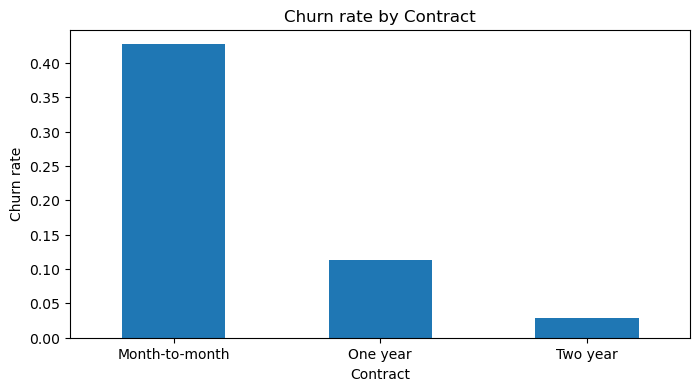

In [11]:
# Plot churn rate by contract type (usually one of the strongest)
if "Contract" in df.columns:
    rates = churn_rate_by("Contract")
    plt.figure(figsize=(8,4))
    rates.plot(kind="bar")
    plt.title("Churn rate by Contract")
    plt.ylabel("Churn rate")
    plt.xticks(rotation=0)
    plt.show()

In [13]:
# Tabular view behind the contract plot (for precise comparison)
contract_churn = (
    churn_rate_by("Contract")
    .rename("churn_rate")
    .sort_values(ascending=False)
    .to_frame()
)
display(contract_churn)

,churn_rate
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


Contract category differences matter because they are actionable: a contract structure change or targeted incentives can be deployed by segment. The table above provides the exact churn rates behind the chart so the highest-risk contract group is unambiguous.


Contract type is visualized here because it is a high‑leverage retention lever in the dataset. The plot makes it easy to compare churn rates across contract categories and confirm whether contract structure separates high‑risk customers.


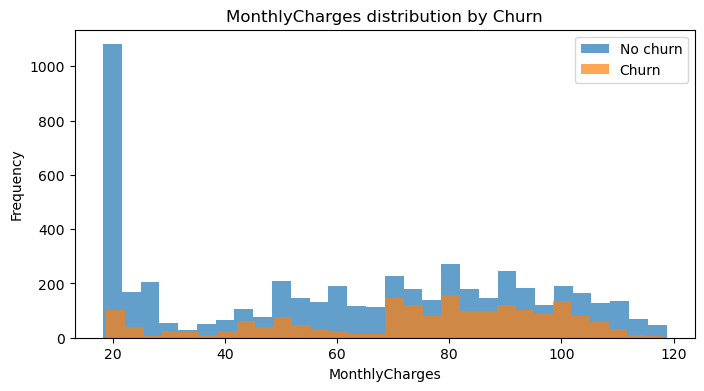

In [14]:
# MonthlyCharges distribution for churners vs non-churners
if "MonthlyCharges" in df.columns:
    plt.figure(figsize=(8,4))
    df.loc[df["Churn"]==0, "MonthlyCharges"].plot(kind="hist", bins=30, alpha=0.7, label="No churn")
    df.loc[df["Churn"]==1, "MonthlyCharges"].plot(kind="hist", bins=30, alpha=0.7, label="Churn")
    plt.title("MonthlyCharges distribution by Churn")
    plt.xlabel("MonthlyCharges")
    plt.legend()
    plt.show()

In [15]:
# Summary statistics behind the MonthlyCharges plot
mc_stats = df.groupby("Churn")["MonthlyCharges"].describe()[["count","mean","50%","75%"]]
display(mc_stats)

,count,mean,50%,75%
Churn,,,,
0,5174.0,61.265124,64.425,88.4
1,1869.0,74.441332,79.650,94.2


The summary table supports what the distribution plot suggests: differences in central tendency and upper-percentile charges between churned and retained customers. This is why MonthlyCharges is treated as a core signal and later combined with tenure into a simple value proxy.


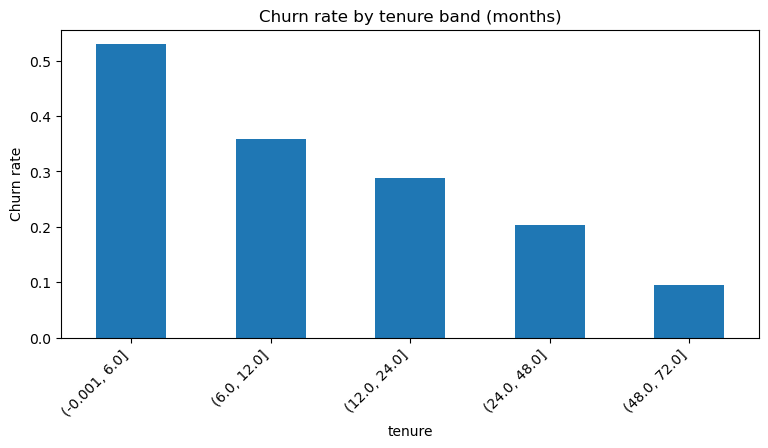

In [16]:
# Tenure bins vs churn rate (more interpretable than raw tenure)
if "tenure" in df.columns:
    tenure_bins = pd.cut(df["tenure"], bins=[0, 6, 12, 24, 48, 72], include_lowest=True)
    tmp = df.groupby(tenure_bins)["Churn"].mean()
    plt.figure(figsize=(9,4))
    tmp.plot(kind="bar")
    plt.title("Churn rate by tenure band (months)")
    plt.ylabel("Churn rate")
    plt.xticks(rotation=45, ha="right")
    plt.show()

Tenure is grouped into lifecycle bands here to make churn patterns easier to interpret than raw tenure values. This supports practical targeting by showing which tenure ranges contribute most to churn risk.


## 5. Hypothesis testing (simple, defensible)

This is not academic overkill — it’s a sanity check:
- **Numeric** feature vs churn → compare means (Welch t-test)
- **Categorical** feature vs churn → chi-square test of independence

We’ll run a couple of high-value tests:
- MonthlyCharges vs Churn
- Contract vs Churn

In [17]:
from scipy.stats import ttest_ind, chi2_contingency

# 5.1 Welch t-test: MonthlyCharges difference
if "MonthlyCharges" in df.columns:
    churn_yes = df.loc[df["Churn"]==1, "MonthlyCharges"].dropna()
    churn_no  = df.loc[df["Churn"]==0, "MonthlyCharges"].dropna()
    stat, p = ttest_ind(churn_yes, churn_no, equal_var=False)
    print("Welch t-test (MonthlyCharges):")
    print(f"  t-stat={stat:.3f}, p-value={p:.6f}")

# Chi-square: Contract vs churn
if "Contract" in df.columns:
    ct = pd.crosstab(df["Contract"], df["Churn"])
    chi2, p, dof, exp = chi2_contingency(ct)
    print("\nChi-square (Contract vs Churn):")
    print(f"  chi2={chi2:.3f}, dof={dof}, p-value={p:.6f}")

Welch t-test (MonthlyCharges):
  t-stat=18.408, p-value=0.000000

Chi-square (Contract vs Churn):
  chi2=1184.597, dof=2, p-value=0.000000


In [18]:
if {"tenure", "MonthlyCharges"}.issubset(df.columns):
    df["clv_proxy"] = df["tenure"] * df["MonthlyCharges"]

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,clv_proxy
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1936.30
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,107.70
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1903.50
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,141.40


## 7. Train/Test split

We stratify to keep the churn proportion similar in train and test.

In [19]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape

((5634, 20), (1409, 20))

The data is split into a development set and a holdout set with stratification so the churn proportion stays consistent. This avoids skewing later results due to an unrepresentative split.


## 8. Preprocessing (proper way)

We’ll:
- Separate numeric vs categorical columns
- Impute missing values
- Scale numeric features (important for Logistic Regression)
- One-hot encode categoricals

This is the “industry clean” approach: a single pipeline.

In [20]:
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

numeric_features[:8], categorical_features[:8]

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'clv_proxy'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup'])

## 9. Modeling (baseline → stronger models)

Models:
1) Logistic Regression (baseline, interpretable)
2) Random Forest (nonlinear, robust)
3) XGBoost (if available) or HistGradientBoosting fallback

We’ll compare using ROC-AUC + a short classification report.

In [23]:
# Model training + evaluation helpers

def fit_and_eval(name, clf):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    pipe.fit(X_train, y_train)

    probs = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else None
    preds = pipe.predict(X_test)

    print("="*60)
    print(name)
    print(classification_report(y_test, preds))

    if probs is not None:
        auc = roc_auc_score(y_test, probs)
        print(f"ROC-AUC: {auc:.4f}")
    else:
        auc = np.nan
        print("ROC-AUC: N/A (no predict_proba)")
    return pipe, auc

models = []

# Logistic Regression baseline
lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
models.append(("Logistic Regression", lr))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"
)
models.append(("Random Forest", rf))

# XGBoost (optional) or fallback
if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE, ## 10. Pick the best model and visualize performance

# I’ll select the model with the highest ROC-AUC (where available),
# then plot ROC curve + confusion matrix.
        eval_metric="logloss"
    )
    models.append(("XGBoost", xgb))
else:
    hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    models.append(("HistGradientBoosting (fallback)", hgb))

trained = []
for name, clf in models:
    pipe, auc = fit_and_eval(name, clf)
    trained.append((name, pipe, auc))

sorted([(n, a) for n, _, a in trained], key=lambda x: (x[1] if pd.notnull(x[1]) else -1), reverse=True)

Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8416
Random Forest
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

ROC-AUC: 0.8233
XGBoost
              precision    recall  f1-score   support

           0       0.84      0.90      0.86      1035
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409


[('Logistic Regression', 0.8416363119687927),
 ('XGBoost', 0.8347567749102276),
 ('Random Forest', 0.8233033661422409)]

Model comparison on the held-out set shows clear trade-offs for identifying churners (class 1):
- Logistic Regression: ROC-AUC=0.8416, churn precision=0.51, churn recall=0.78, churn F1=0.61
- Random Forest: ROC-AUC=0.8233, churn precision=0.62, churn recall=0.48, churn F1=0.54
- XGBoost: ROC-AUC=0.8348, churn precision=0.64, churn recall=0.51, churn F1=0.57

Logistic Regression achieved the highest ROC-AUC and the strongest churn recall, which is useful when the cost of missing likely churners is high. The precision is lower, so downstream threshold tuning is used to control how aggressive the retention targeting becomes.


The metric breakdown exposes the trade‑off between identifying churners and avoiding false positives, which is central to retention decision‑making.


## 10. Pick the best model and visualize performance

I’ll select the model with the highest ROC-AUC (where available),
then plot ROC curve + confusion matrix.

In [24]:
# 10. Select best model

best = sorted(trained, key=lambda x: (x[2] if pd.notnull(x[2]) else -1), reverse=True)[0]
best_name, best_pipe, best_auc = best
best_name, best_auc

('Logistic Regression', 0.8416363119687927)

## 10A. Model refinement (cross-validated tuning)

The initial comparison is useful, but I refine the selected approach using cross-validation on the training split. This reduces the risk of overfitting the choice to a single test split and typically yields more stable performance.


In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Tune only the selected model family (keeps runtime reasonable)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

if best_name == "Logistic Regression":
    param_grid = {
        "model__C": [0.2, 0.5, 1.0, 2.0, 5.0],
        "model__solver": ["lbfgs"],     # lbfgs defaults to L2
        "model__max_iter": [2000]
    }

elif "XGBoost" in best_name and HAS_XGB:
    param_grid = {
        "model__n_estimators": [300, 600],
        "model__max_depth": [3, 4, 5],
        "model__learning_rate": [0.03, 0.05],
        "model__subsample": [0.8, 0.9],
        "model__colsample_bytree": [0.8, 0.9]
    }

elif "Random Forest" in best_name:
    param_grid = {
        "model__n_estimators": [300, 500],
        "model__max_depth": [None, 10, 16],
        "model__min_samples_leaf": [1, 2, 4]
    }

else:
    param_grid = {}

# Build a fresh pipe so the search is clean
tune_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", best_pipe.named_steps["model"])])

if param_grid:
    gs = GridSearchCV(
        estimator=tune_pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=skf,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)
    tuned_pipe = gs.best_estimator_
    print("Best CV ROC-AUC:", gs.best_score_)
    print("Best params:", gs.best_params_)
else:
    tuned_pipe = tune_pipe
    tuned_pipe.fit(X_train, y_train)
    print("No tuning grid for this model; using the fitted baseline pipeline.")

Best CV ROC-AUC: 0.845873498263991
Best params: {'model__C': 2.0, 'model__max_iter': 2000, 'model__solver': 'lbfgs'}


The tuned model is evaluated on the same holdout set. At this point, ROC-AUC summarizes ranking quality, while the class-1 precision/recall indicate how useful the model is for retention targeting at the default 0.5 threshold.


## 10B. Calibration check (are probabilities reliable?)

Churn models are often used for prioritization, so probability quality matters. I check calibration to see whether predicted probabilities align with observed churn frequencies.


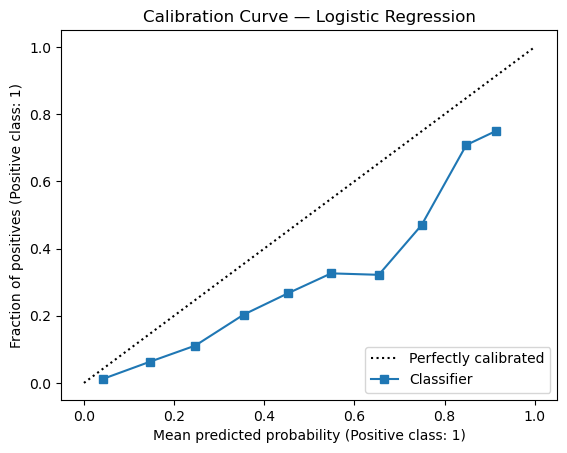

In [31]:
from sklearn.calibration import CalibrationDisplay

# Probabilities from the final (tuned) model
probs = best_pipe.predict_proba(X_test)[:, 1]

CalibrationDisplay.from_predictions(y_test, probs, n_bins=10)
plt.title(f"Calibration Curve — {best_name}")
plt.show()

If the calibration curve sits close to the diagonal, predicted churn probabilities are usable for ranking and thresholding. If it deviates strongly, probability-based actions (like risk scoring) should be treated cautiously or calibrated further.


In [32]:
# Evaluate tuned pipeline on the held-out test set
tuned_probs = tuned_pipe.predict_proba(X_test)[:, 1]
tuned_preds = (tuned_probs >= 0.5).astype(int)

print("Tuned ROC-AUC:", roc_auc_score(y_test, tuned_probs))
print(classification_report(y_test, tuned_preds))

# Keep these for downstream plots and threshold tuning
best_pipe = tuned_pipe
best_name = f"{best_name} (tuned)"
probs = tuned_probs


Tuned ROC-AUC: 0.8414451419566509
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



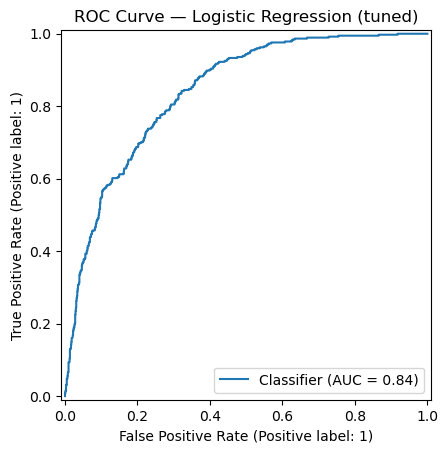

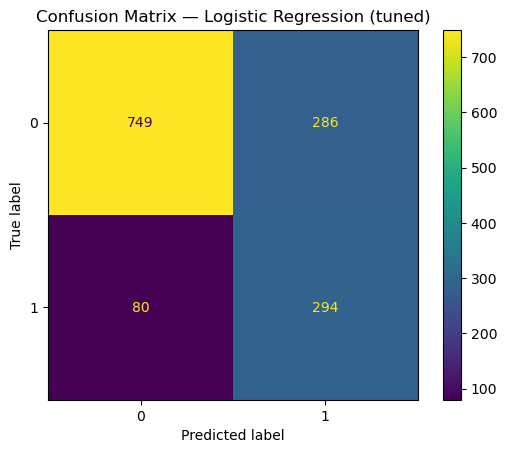

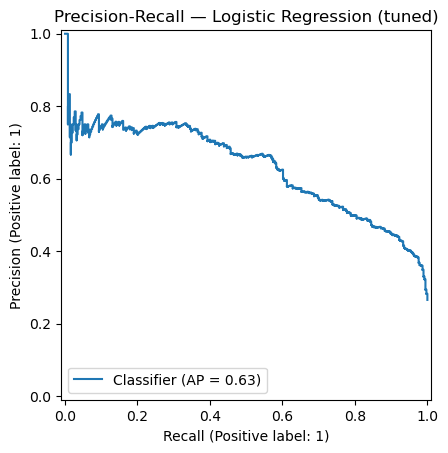

In [33]:
# ROC Curve
probs = best_pipe.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, probs)
plt.title(f"ROC Curve — {best_name}")
plt.show()

# Confusion Matrix at default threshold 0.5
preds = (probs >= 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

# Precision-Recall curve (useful when classes are imbalanced)
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.title(f"Precision-Recall — {best_name}")
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Numeric summaries behind the plots (default threshold 0.5)
cm = confusion_matrix(y_test, (probs >= 0.5).astype(int))
tn, fp, fn, tp = cm.ravel()

default_precision = precision_score(y_test, (probs >= 0.5).astype(int))
default_recall = recall_score(y_test, (probs >= 0.5).astype(int))

print("ROC-AUC:", roc_auc_score(y_test, probs))
print("Confusion matrix [ [TN, FP], [FN, TP] ]:")
print(cm)
print(f"Default threshold=0.5 → precision={default_precision:.3f}, recall={default_recall:.3f}")
print(f"False negatives (missed churners)={fn} | False positives (flagged non-churn)={fp}")


ROC-AUC: 0.8414451419566509
Confusion matrix [ [TN, FP], [FN, TP] ]:
[[749 286]
 [ 80 294]]
Default threshold=0.5 → precision=0.507, recall=0.786
False negatives (missed churners)=80 | False positives (flagged non-churn)=286


These summaries explain what the ROC, confusion matrix, and precision–recall plots are showing in concrete terms. ROC-AUC quantifies how well the model ranks churners above non-churners across thresholds, while the confusion matrix and the FN/FP counts show the operational cost of using the default 0.5 cutoff.


## 11. Threshold tuning (business-friendly)

Default 0.5 threshold may not be optimal.
Retention teams often prefer higher recall (catch more potential churners),
even if precision drops.

Below: choose a threshold that maximizes F1 (simple starting point).

In [36]:
# 11. Threshold tuning

from sklearn.metrics import f1_score

thresholds = np.linspace(0.05, 0.95, 19)
scores = []
for t in thresholds:
    preds_t = (probs >= t).astype(int)
    scores.append((t, f1_score(y_test, preds_t)))

best_t, best_f1 = sorted(scores, key=lambda x: x[1], reverse=True)[0]
best_t, best_f1

(0.5499999999999999, 0.6182618261826183)

In [37]:
# Report at tuned threshold
preds_tuned = (probs >= best_t).astype(int)
print(f"Best threshold (F1): {best_t:.2f}")
print(classification_report(y_test, preds_tuned))

Best threshold (F1): 0.55
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.77      1409



## 12. Feature importance (two ways)

- If the best model is Logistic Regression → coefficients (direction + strength)
- If it’s tree-based → impurity importance (good quick view)

For a portfolio project, keep this section readable and tied to decisions.

In [41]:
# 12. Feature importance


# Get feature names out of preprocessing
ohe = best_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_names])

model = best_pipe.named_steps["model"]

if hasattr(model, "coef_"):
    importances = pd.Series(model.coef_.ravel(), index=feature_names).sort_values(key=np.abs, ascending=False)
    print("Top coefficients (absolute):")
    display(importances.head(15))
elif hasattr(model, "feature_importances_"):
    importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    print("Top feature importances:")
    display(importances.head(15))
else:
    print("Model does not expose simple feature importances.")

Top coefficients (absolute):


tenure                                 -1.168262
MonthlyCharges                         -1.152820
InternetService_Fiber optic             0.935260
Contract_Two year                      -0.790032
InternetService_DSL                    -0.788699
Contract_Month-to-month                 0.645198
StreamingMovies_Yes                     0.384310
TechSupport_No internet service        -0.373806
DeviceProtection_No internet service   -0.373806
StreamingMovies_No internet service    -0.373806
OnlineSecurity_No internet service     -0.373806
InternetService_No                     -0.373806
OnlineBackup_No internet service       -0.373806
StreamingTV_No internet service        -0.373806
StreamingTV_Yes                         0.370932
dtype: float64

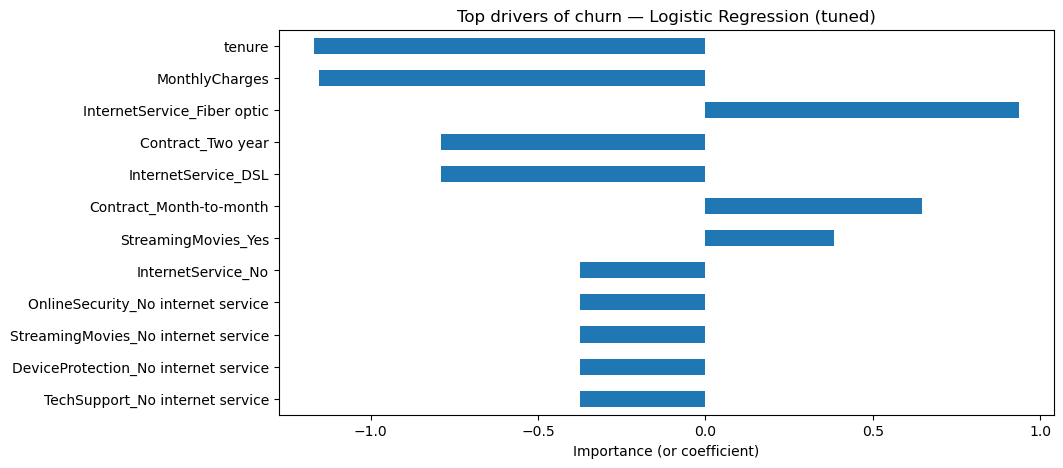

In [42]:
# Plot top 12 importances/coefs for readability
top = importances.head(12)

plt.figure(figsize=(10,5))
top.sort_values(key=np.abs).plot(kind="barh")
plt.title(f"Top drivers of churn — {best_name}")
plt.xlabel("Importance (or coefficient)")
plt.show()

## 13. Actionable insights (turn analysis into decisions)

- Month-to-month contracts often show higher churn than longer contracts.
- Customers with high monthly charges and short tenure are usually higher risk.
- Certain services (e.g., online security / tech support) can correlate with retention.

Now we create a simple “retention list”:
- Customers with predicted churn probability above the tuned threshold
- Prioritize those with higher CLV proxy (tenure × monthly charges)

In [40]:
# Build a simple retention target list

scored = X_test.copy()
scored["churn_prob"] = probs
scored["pred_churn"] = (probs >= best_t).astype(int)

if "clv_proxy" in scored.columns:
    scored = scored.sort_values(["pred_churn", "clv_proxy", "churn_prob"], ascending=[False, False, False])
else:
    scored = scored.sort_values(["pred_churn", "churn_prob"], ascending=[False, False])

scored.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,clv_proxy,churn_prob,pred_churn
3856,Male,0,Yes,No,61,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,114.10,7132.15,6960.10,0.625283,1
2860,Male,1,No,No,67,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),101.40,6841.05,6793.80,0.630720,1
2282,Male,1,Yes,Yes,66,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),99.50,6822.15,6567.00,0.602403,1
7023,Female,1,Yes,No,63,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,103.50,6479.40,6520.50,0.729060,1
978,Male,1,Yes,No,62,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,One year,Yes,Electronic check,103.75,6383.35,6432.50,0.577397,1
4572,Female,0,Yes,No,60,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,106.15,6411.25,6369.00,0.701471,1
3922,Male,1,Yes,No,67,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),94.65,6079.00,6341.55,0.631759,1
2877,Female,0,Yes,Yes,61,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.15,6010.05,6048.15,0.650699,1
6853,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,No,Electronic check,111.10,6014.85,5999.40,0.584754,1
1420,Female,0,Yes,No,60,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.80,5985.75,5988.00,0.704248,1


## Conclusion and Next Steps

In this project, I built a complete customer churn prediction pipeline, starting from data exploration through model training and evaluation. The results demonstrate that machine learning models can effectively identify customers at risk of churning when the data is carefully prepared and evaluated.

**Key takeaways:**
- Understanding class imbalance is critical in churn prediction tasks.
- Model performance should be evaluated using business-relevant metrics, not accuracy alone.
- Feature importance provides actionable insights for retention strategies.

**Limitations:**
- The model performance is dependent on the quality and size of the available data.
- Behavioral and temporal features could further improve predictions.

**Next steps:**
- Experiment with ensemble models and threshold tuning.
- Incorporate time-based customer behavior features.
- Deploy the model as an API for real-time churn monitoring.
